## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm -q

!sudo apt install tesseract-ocr -q
!pip install pytesseract -q

! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers -q

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 797, done.
remote: Total 797 (delta 0), reused 0 (delta 0), pack-reused 797
Receiving objects: 100% (797/797), 439.18 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (441/441), done.
     |████████████████████████████████| 645kB 12.8MB/s 
     |████████████████████████████████| 204kB 21.2MB/s 
     |████████████████████████████████| 5.5MB 25.0MB/s 
     |████████████████████████████████| 5.6MB 37.6MB/s 
     |████████████████████████████████| 1.2MB 19.8MB/s 
     |████████████████████████████████| 901kB 40.9MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After t

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [2]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

--2021-06-15 12:00:51--  https://guillaumejaume.github.io/FUNSD/dataset.zip
Resolving guillaumejaume.github.io (guillaumejaume.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to guillaumejaume.github.io (guillaumejaume.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16838830 (16M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.06M  41.1MB/s    in 0.4s    

2021-06-15 12:00:52 (41.1 MB/s) - ‘dataset.zip’ saved [16838830/16838830]

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training_data/
  inflating: dataset/training_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset/
   creating: __MACOSX/dataset/training_data/
  inflating: __MACOSX/dataset/training_data/._.DS_Store  
   creating: dataset/training_data/images/
  inflating: dataset/training_data/images/92091873.png  
   creating: __MACOSX/dataset/training_data/image

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

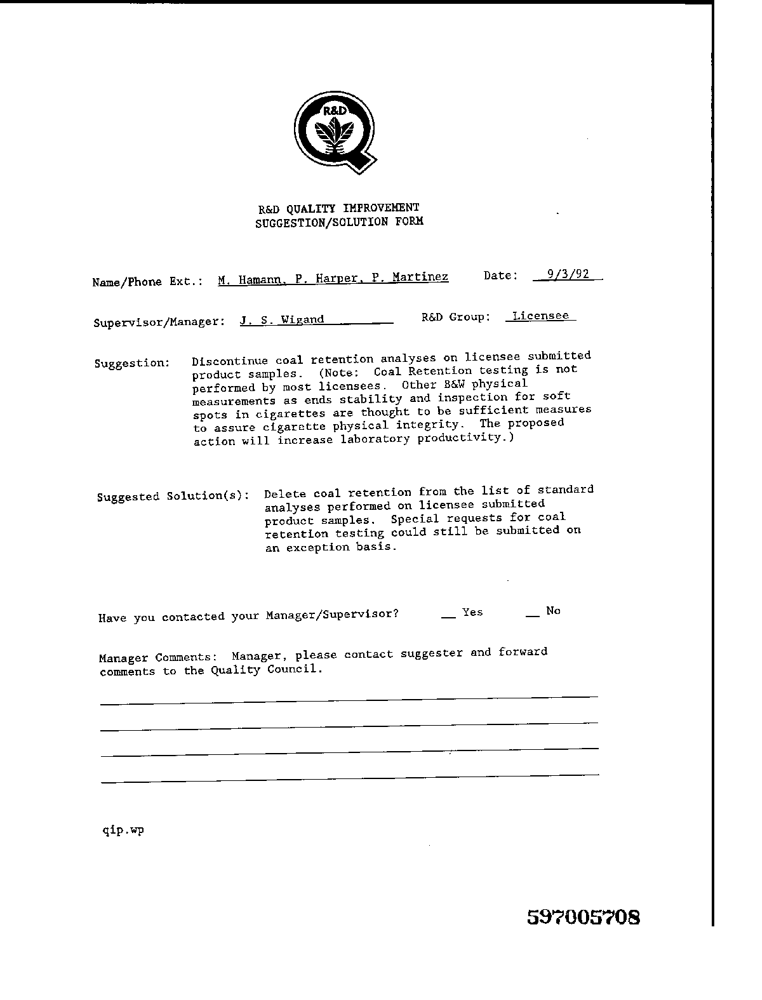

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/0000971160.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [8]:
import json

with open('/content/data/training_data/annotations/0000971160.json') as f:
  data = json.load(f)

# for annotation in data['form']:
#   print(annotation)

### Annotated Training Example

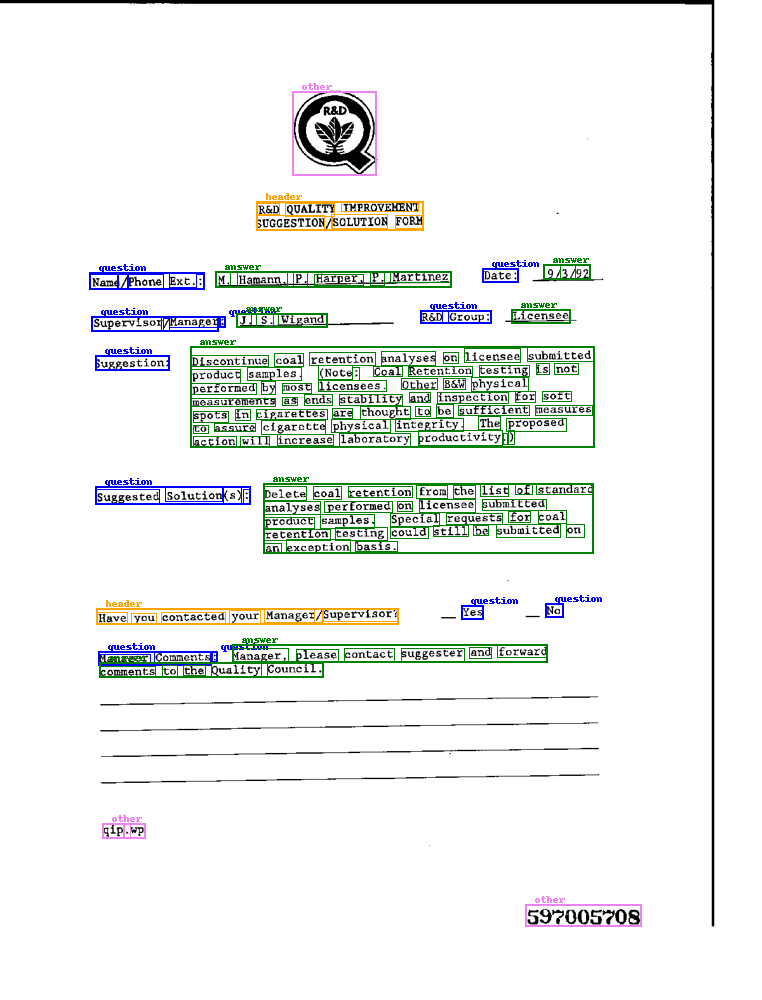

In [9]:
from PIL import Image, ImageDraw, ImageFont
import json

# Load Image
image = Image.open("/content/data/training_data/images/0000971160.png")
image = image.convert("RGB")

# Load ground truth annottations
with open('/content/data/training_data/annotations/0000971160.json') as f:
  data = json.load(f)


draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the Train-Test data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [7]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Downloading: 100% 606/606 [00:00<00:00, 470kB/s]
Downloading: 100% 232k/232k [00:00<00:00, 1.40MB/s]
Downloading: 100% 466k/466k [00:00<00:00, 2.69MB/s]
Downloading: 100% 112/112 [00:00<00:00, 83.9kB/s]
Downloading: 100% 170/170 [00:00<00:00, 127kB/s]


### Extracting the labels
We create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [8]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

#### Define a PyTorch dataset to store labels

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [9]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}

# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [10]:
print(labels)

['B-ANSWER', 'B-HEADER', 'B-QUESTION', 'E-ANSWER', 'E-HEADER', 'E-QUESTION', 'I-ANSWER', 'I-HEADER', 'I-QUESTION', 'O', 'S-ANSWER', 'S-HEADER', 'S-QUESTION']


### Creating Dataloader for Train and Test Data
Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [11]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

print(f"Train Data : {len(train_dataloader)}")

print(f"Test Data : {len(eval_dataloader)}")

Train Data : 75
Test Data : 26


#### Tokenized document example

In [12]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] 530 : payroll : 700 other ( date ) ( signature ) 92314414 loews / lorillard public affairs committee contribution identity card 274 - 38 - 3042 andrew tisch complete either a or b below : a. i hereby authorize, until further notice, a voluntary contribution by salary deduction to the loews / lorillard public affairs committee ( lopac ) of the following amount per pay period : $ 1. 00 $ 4. 00 $ 2. 00 $ 20. 00 ( please specify ) b. enclosed is a check or money order in the amount of $ as a contribution to lopac. my contribution is voluntary. i am aware of my right to refuse to contribute without reprisal of aware of the political any kind. i am purpose of lopac. i am aware that a copy of the report of lopac is filed with available the federal election commission and is for purchase. i am aware that the guidelines above as to the amount of my contribution are only suggestions. am aware that my contribution american counts against my individual contribution limit. i am an citizen or

## Fine-Tuning the model

Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

#### Download the pre-trained model

In [13]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

### Training the model

In [14]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 25
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 0 steps: 2.554811954498291


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.35it/s]

Loss after 100 steps: 0.7122061252593994


Training:  67%|██████▋   | 50/75 [00:21<00:10,  2.30it/s]

Loss after 200 steps: 0.48998332023620605


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 300 steps: 0.14317288994789124


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.28it/s]

Loss after 400 steps: 0.29646557569503784


Training:  67%|██████▋   | 50/75 [00:21<00:10,  2.28it/s]

Loss after 500 steps: 0.13951995968818665


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 600 steps: 0.06704220920801163


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.27it/s]

Loss after 700 steps: 0.038069818168878555


Training:  67%|██████▋   | 50/75 [00:21<00:10,  2.28it/s]

Loss after 800 steps: 0.02644864097237587


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 900 steps: 0.0218059029430151


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.29it/s]

Loss after 1000 steps: 0.01468315813690424


Training:  67%|██████▋   | 50/75 [00:21<00:10,  2.28it/s]

Loss after 1100 steps: 0.029065541923046112


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 1200 steps: 0.012571793980896473


Training:  33%|███▎      | 25/75 [00:10<00:22,  2.26it/s]

Loss after 1300 steps: 0.0029672938399016857


Training:  67%|██████▋   | 50/75 [00:21<00:11,  2.27it/s]

Loss after 1400 steps: 0.09330424666404724


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 1500 steps: 0.04077355936169624


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.28it/s]

Loss after 1600 steps: 0.01114417053759098


Training:  67%|██████▋   | 50/75 [00:21<00:11,  2.27it/s]

Loss after 1700 steps: 0.00793659407645464


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 1800 steps: 0.034527555108070374


Training: 100%|██████████| 75/75 [00:32<00:00,  2.28it/s]


### Saving the model

In [19]:
torch.save(model.state_dict(), "/content/saved_models/layoutlm_finetuned_15062021.pth")

### Loading the model

In [20]:
# model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.load_state_dict(torch.load("/content/saved_models/layoutlm_finetuned_15062021.pth"))

<All keys matched successfully>

## Evaluation

Now let's evaluate on the test set:

In [21]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]


{'loss': 1.3490949926468043, 'precision': 0.7031318923687693, 'recall': 0.7973986993496749, 'f1': 0.7473042662916081}


## Pre-processing unseen custom images and getting predictions

Inference

We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [ ]:
def prepare_image_for_model(path_to_image):
    """
    Read a custom image and preprocess it into the required format for model
    """
    import numpy as np
    import pytesseract

    # Read Image
    image = Image.open(path_to_image)
    image = image.convert("RGB")

    # Load image data in a dataframe using pytesseract
    width, height = image.size
    w_scale = 1000/width
    h_scale = 1000/height

    ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
                
    ocr_df = ocr_df.dropna() \
                  .assign(left_scaled = ocr_df.left*w_scale,
                          width_scaled = ocr_df.width*w_scale,
                          top_scaled = ocr_df.top*h_scale,
                          height_scaled = ocr_df.height*h_scale,
                          right_scaled = lambda x: x.left_scaled + x.width_scaled,
                          bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)

    # Extract text, bounding boxes in lists
    words = list(ocr_df.text)
    coordinates = ocr_df[['left', 'top', 'width', 'height']]
    actual_boxes = []
    for idx, row in coordinates.iterrows():
        x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
        actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
        actual_boxes.append(actual_box)

    def normalize_box(box, width, height):
        return [
            int(1000 * (box[0] / width)),
            int(1000 * (box[1] / height)),
            int(1000 * (box[2] / width)),
            int(1000 * (box[3] / height)),
        ]

    boxes = []
    for box in actual_boxes:
        boxes.append(normalize_box(box, width, height))

    return words, boxes, actual_boxes

In [4]:
image_name = "82491256.png"
path_to_image = "/content/data/testing_data/images/"+image_name
path_to_annotations = "/content/data/testing_data/annotations/"+image_name.replace(".png",".json")

In [ ]:
words, boxes, actual_boxes = prepare_image_for_model(path_to_image)

### Convert to features

This should become the future API of LayoutLMTokenizer (`prepare_for_model()`): 

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

To get back text from encoded features

In [ ]:
# tokenizer.decode(input_ids)

Now let's perform a forward pass!

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)

# print(input_ids.shape)
# print(attention_mask.shape)
# print(token_type_ids.shape)
# print(bbox.shape)

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512, 4])


### Scoring

In [ ]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
# print(outputs)
# print(outputs.logits.shape)
# print(outputs.logits.argmax(-1))
# print()

### Get Predictions at word level

Of course, LayoutLM outputs labels at the token level, but we are interested in the predicted labels at the word level. So we should actually only incorporate the predicted labels of tokens that are the first token of a given word: 

In [ ]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

print(word_level_predictions)
print(len(word_level_predictions))
print(len(final_boxes))

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 4, 9, 9, 9, 9, 12, 12, 0, 6, 6, 3, 2, 12, 0, 10, 10, 3, 3, 2, 8, 5, 5, 0, 3, 12, 5, 10, 0, 6, 3, 2, 5, 0, 6, 3, 3, 3, 2, 5, 0, 6, 3, 3, 3, 12, 5, 0, 6, 6, 6, 3, 12, 5, 0, 6, 6, 3, 3, 6, 3, 6, 3, 3, 3, 2, 8, 8, 8, 5, 5, 5, 0, 9, 10, 9, 7, 7, 7, 4, 4, 12, 9, 9, 9, 9, 9, 9, 9, 9, 8, 0, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
229
229


In [ ]:
def draw_image(annotations, boxes, path_to_image):
    # Read Image
    image = Image.open(path_to_image)
    image = image.convert("RGB")
    draw = ImageDraw.Draw(image)

    font = ImageFont.load_default()

    def iob_to_label(label):
      if label != 'O':
        return label[2:]
      else:
        return "other"

    label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

    for prediction, box in zip(annotations, boxes):
        predicted_label = iob_to_label(label_map[prediction]).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

    return image

#### Visualizing the predicted results

In [ ]:
# path_to_image = "/content/data/testing_data/images/83443897.png"
image = draw_image(word_level_predictions,final_boxes, path_to_image)
image

# Post - Processing the results

Here the idea is to generate question and answer pairs based on the predicted labels

### Get words from tokens

In [ ]:
words_list = []
for id in input_ids.squeeze().tolist():
  words_list.append(tokenizer.decode([id]))

words_list1 = ' '.join([x for x in words_list if x!='[PAD]' and x!='[CLS]' and x!='[SEP]'])
final_words = words_list1.replace(' ##', '').split(" ")
print(final_words[0:30])

### Combine B - I - E tags

Every sequence gets the labels B-, I-, E- or S-, which indicate begining, intermediate, end or single. The idea is to combine the predicted lables of these words at a sequenc level to get labels of sequences.

In [ ]:
def reverse_tags(word_level_predictions, final_words, final_boxes):

    # el : entities indices list
    # lbl : lables for entities
    # f1 : flag for checking a started entity

    prev = ''
    el = []
    lbl = []
    temp = []
    f1 = 0
    pred = [label_map[i] for i in word_level_predictions]
    for i in range(len(final_words)):
        
    #     entity = ''
        if pred[i] == 'O':
            if f1 == 1:
                f1 = 0
                el.append(temp)
                lbl.append(prev)
                temp = []
            el.append([i])
            lbl.append('O')
            continue
        t1 , tag = pred[i].split('-')
        if t1 == 'S':
            if f1 == 1:
                f1 = 0
                el.append(temp)
                lbl.append(prev)
                temp = []
            el.append([i])
            lbl.append(tag)
    #         prev = 'S'
            continue
        if t1 == 'B':
            if f1 == 1:
                f1 = 0
                el.append(temp)
                lbl.append(prev)
                temp = []        
            f1 = 1
            temp.append(i)
            prev = tag
            continue
        if t1 == 'I':
            if f1 == 1:
                if (not (prev == tag)):
                    f1 = 0
                    el.append(temp)
                    lbl.append(prev)
                    temp = []        
                else:
                    temp.append(i)
            else:
                f1 = 1
                temp.append(i)
                prev = tag
            continue
        if t1 == 'E':
            if f1 == 1:
                if (not (prev == tag)):
                    f1 = 0
                    el.append(temp)
                    lbl.append(prev)
                    temp = []        
                else:
                    f1 = 0
                    temp.append(i)
                    el.append(temp)
                    lbl.append(prev)
                    temp = []
            else:
    #             f1 = 1
    #             temp.append(i)
                el.append([i])
                lbl.append(tag)
    #             prev = tag
            continue
    if f1 == 1:
        f1 = 0
    #     temp.append(i)
        el.append(temp)
        lbl.append(prev)

   # combine ents
    ents = []
    for i in range(len(el)):
        ent = ''
        for ind in el[i]:
            ent = ent + ' ' + final_words[ind]
        ents.append(ent.strip())

    # Combine entity boxes
    ent_boxs = []
    for i in range(len(el)):
        b1 = final_boxes[el[i][0]]
        b2 = final_boxes[el[i][-1]]
        ent_boxs.append([b1[0],b1[1],b2[2],b2[3]])

    return ents, ent_boxs, lbl

In [ ]:
ents, ent_boxs, labels = reverse_tags(word_level_predictions, final_words, final_boxes)
print(ents)

### Entity Linking using proximity

Linking question and answer pairs based proximity of bounding boxes

In [10]:
def link_ents(ents,ent_boxs,labels):

    import copy

    #Copy of the text and object arrays
    texts_copied = copy.deepcopy(ents)
    texts_boxes_copied = copy.deepcopy(ent_boxs)
    labels_copied = copy.deepcopy(labels)

    # Computer a Matrix similarity of distances of the text and object
    def calc_sim(text, obj, x_and_y="N"):

        x1 = text[0]
        x2 = text[2]
        y1 = text[1]
        y2 = text[3]

        x11 = obj[0]
        x22 = obj[2]
        y11 = obj[1]
        y22 = obj[3]

        x_dist = x11 - x2
        y_dist = y11-y2

        return x_dist, y_dist

    def merge_boxes(box1, box2):
        return [min(box1[0], box2[0]), 
            min(box1[1], box2[1]), 
            max(box1[2], box2[2]),
            max(box1[3], box2[3])]

    #Principal algorithm for merge text 
    def merge_algo(texts, texts_boxes, labels):
        texts_c = texts
        texts_boxes_c = texts_boxes
        labels_c = labels
        pairs = []
        nonpairs = []
        for i, (text_1, text_box_1, label_1) in enumerate(zip(texts, texts_boxes, labels)):
            for j, (text_2, text_box_2, label_2) in enumerate(zip(texts, texts_boxes, labels)):
                # if j <= i:
                #     continue
                # Create a new box if a distances is less than disctance limit defined 
                if ((label_1.lower()=="question") & (label_2.lower()=="answer")):
                    xd , yd = calc_sim(text_box_1, text_box_2,"N")
                    if (-50<xd<=50)&(-25<=yd<=30):
                        # Create a new box  
                        print("----------------")
                        print(f"""Between {text_1} = {label_1} and {text_2} = {label_2} \n""")
                        print(f"""x_distance: {xd}, y_distance: {yd}""")
                        new_box = merge_boxes(text_box_1, text_box_2)
                        texts_boxes[i] = new_box
                        #delete previous text boxes
                        del texts_boxes[j]
                        # Create a new text string 
                        new_text = text_1 + ' ' + text_2
                        texts[i] = new_text
                        #delete previous text
                        del texts[j]
                        new_label = "PAIR"
                        labels[i]= new_label
                        del labels[j]
                        print(f"""new label ===== {new_label}""")
                        print("xxxxxx----xxxxxx")

        assert len(texts)==len(texts_boxes)
        assert len(texts)==len(labels)

        return texts, texts_boxes, labels

    texts_copied1, texts_boxes_copied1, labels_copied1 = merge_algo(texts_copied, texts_boxes_copied, labels_copied)
    return texts_copied1, texts_boxes_copied1, labels_copied1

For demonstration purpose, we are carrying out entity linking using the ground truth labels


In [20]:
image_name = "82092117.png"
path_to_image = "/content/data/testing_data/images/"+image_name
path_to_annotations = "/content/data/testing_data/annotations/"+image_name.replace(".png",".json")

In [21]:
import json

# Load ground truth annotations
with open(path_to_annotations) as f:
  data = json.load(f)

gt_ents = []
gt_ent_boxs = []
gt_labels = []

for annotation in data['form']:
    label = annotation['label']
    general_box = annotation['box']
    text = annotation['text']
    # words = annotation['words'][0]['text']
    gt_labels.append(label)
    gt_ents.append(text)
    gt_ent_boxs.append(general_box)

texts_copied1, texts_boxes_copied1, labels_copied1 = link_ents(gt_ents,gt_ent_boxs,gt_labels)

----------------
Between TO: = question and George Baroody = answer 

x_distance: 13, y_distance: -17
new label ===== PAIR
xxxxxx----xxxxxx
----------------
Between DATE: = question and 12 /10 /98 = answer 

x_distance: 37, y_distance: -18
new label ===== PAIR
xxxxxx----xxxxxx
----------------
Between Fax: = question and 614 -466 -5087 = answer 

x_distance: 1, y_distance: -16
new label ===== PAIR
xxxxxx----xxxxxx
----------------
Between NOTE: = question and THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. If you have received this comunicati

Visualize results

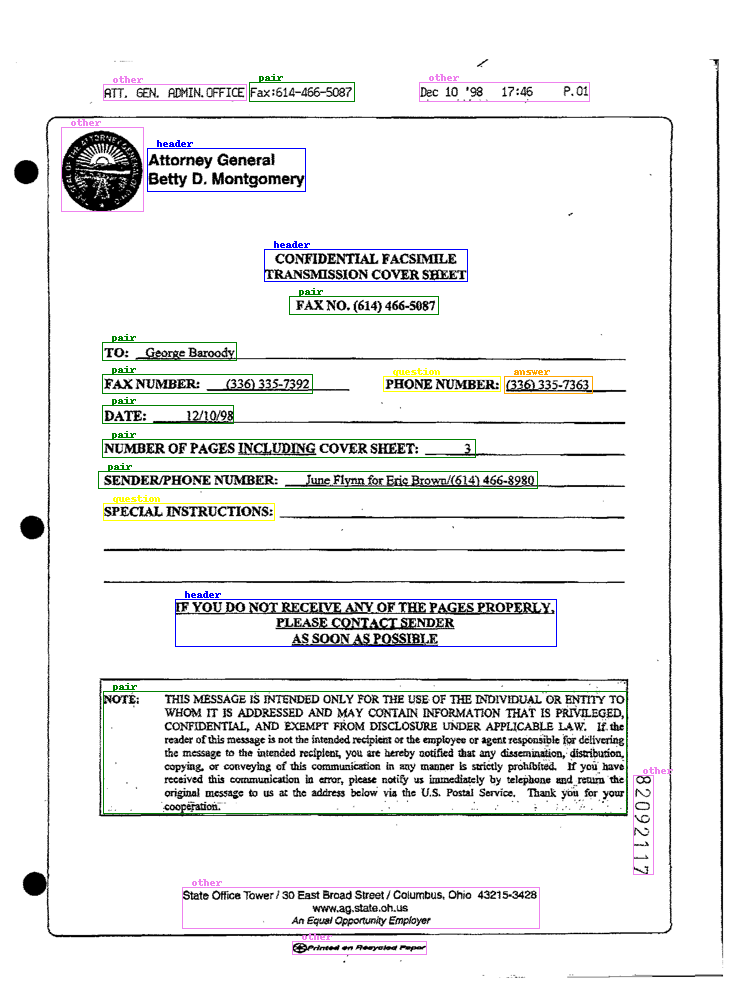

In [22]:
# path_to_image = "/content/data/testing_data/images/82092117.png"
# Read Image
image = Image.open(path_to_image)
image = image.convert("RGB")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    return label.lower()

label2color = {'unpaired':'red','pair':'green', 'question':'yellow', 'answer':'orange', 'header':'blue', 'o':'violet','other':'violet'}

for prediction, box, word in zip(labels_copied1, texts_boxes_copied1, texts_copied1):
    # print(f"""{word} , {prediction}""")
    predicted_label = prediction.lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

# Future Scope

- Using Binary Classification to predict the linkage between question and answer
- Proximity based approach to predict the linkage is not very accurate